# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


# Data Setup


## data download

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:

!unzip "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/train.zip" -d "/content/data2"


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/data2/train/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content

## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
import pandas as pd
import os
import random

from PIL import Image


class CustomMultiLabelRotationDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, id_list=None):
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red', 'green', 'blue', 'yellow']


        df = pd.read_csv(csv_path)
        self.id2label = {row['Id']: row['Target'] for _, row in df.iterrows()}


        all_ids_in_csv = set(self.id2label.keys())
        all_files = os.listdir(img_dir)
        all_ids_on_disk = set(
            fname.split('_')[0] for fname in all_files if fname.endswith('_red.png')
        )
        valid_ids = sorted(all_ids_in_csv & all_ids_on_disk)


        self.available_ids = sorted(set(id_list) & set(valid_ids)) if id_list else valid_ids


        all_labels = set()
        for label_str in self.id2label.values():
            labels = map(int, label_str.split())
            all_labels.update(labels)
        self.label_map = {label: i for i, label in enumerate(sorted(all_labels))}
        self.num_classes = len(self.label_map)

    def __len__(self):
        return len(self.available_ids)

    def __getitem__(self, idx):
        base_id = self.available_ids[idx]
        rotation_angle = random.choice([0, 90, 180, 270])

        channels = []
        for color in self.colors:
            path = os.path.join(self.img_dir, f"{base_id}_{color}.png")
            img = Image.open(path).convert('L')
            img = img.rotate(rotation_angle)
            channels.append(img)

        image = np.stack([np.array(ch) for ch in channels], axis=0)
        image = torch.from_numpy(image).float() / 255.0

        if self.transform:
            image = self.transform(image)

        multi_hot = torch.zeros(self.num_classes)
        for label in map(int, self.id2label[base_id].split()):
            multi_hot[self.label_map[label]] = 1

        return image, multi_hot

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # transforms.ToTensor()
])

transform_val = transforms.Compose([
    # transforms.ToTensor()
])




In [ ]:
import os
import random
from sklearn.model_selection import train_test_split


img_dir = '/content/data2/train'
all_files = os.listdir(img_dir)
all_ids = sorted(set(
    fname.split('_')[0]
    for fname in all_files if fname.endswith('_red.png')
))


train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

train_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_train,
    id_list=train_ids
)

val_dataset = CustomMultiLabelRotationDataset(
    csv_path='data2/train.csv',
    img_dir=img_dir,
    transform=transform_val,
    id_list=val_ids
)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

torch.Size([64, 28])


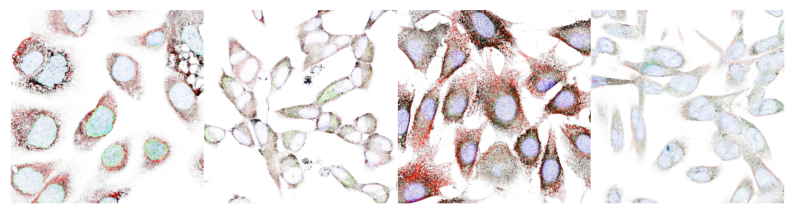

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np


for images, labels in train_loader:

    imgs = images[:4]
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    print(labels.shape)

    npimg = grid.numpy()
    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    break


In [ ]:
# from PIL import Image
# Image.open('data2/train/7adf2db4-bb9b-11e8-b2b9-ac1f6b6435d0_red.png').show()

Show some example images and rotated images with labels:

# Evaluation code

In [ ]:
import time
import torch
from sklearn.metrics import f1_score

def run_test(net, testloader, criterion, threshold=0.5):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    net.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)  # (B, C)
            probs = torch.sigmoid(outputs)  # (B, C)
            preds = (probs > threshold).float()    # threshold

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())


            correct += (preds == labels).float().sum().item()
            total += labels.numel()  # B * C

            # loss
            avg_test_loss += criterion(outputs, labels).item()

    #  batch
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    #  macro F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    avg_test_loss = avg_test_loss / len(testloader)
    acc = 100 * correct / total

    print('TESTING:')
    print(f'Accuracy (per label bit): {acc:.2f} %')
    print(f'Average loss: {avg_test_loss:.4f}')
    print(f'f1: {macro_f1:.4f}')
    return acc / 100  # for compatibility


In [ ]:
def adjust_learning_rate(optimizer, epoch):
    if epoch > 40:
        lr = 1e-5
    elif epoch > 35:
        lr = 3e-5
    elif epoch > 30:
        lr = 7.5e-5
    elif epoch > 25:
        lr = 15e-5
    else:
        lr = 30e-5
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def adjust_learning_rate2(optimizer, epoch, init_lr, decay_epochs=15):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
def save_checkpoint(model, optimizer, epoch, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"📦 Saved checkpoint at epoch {epoch}")

def load_checkpoint(model, optimizer, path='checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']


# Training

In [ ]:
from sklearn.metrics import f1_score
import time

def train(net, criterion, optimizer, num_epochs, init_lr, threshold=0.5, resume=False, ckpt_path='checkpoint.pth'):
    start_epoch = 0


    if resume:
        start_epoch = load_checkpoint(net, optimizer, path=ckpt_path)

    for epoch in range(start_epoch, num_epochs):
        # adjust_learning_rate(optimizer, epoch)
        adjust_learning_rate2(optimizer, epoch, init_lr)

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, labels) in enumerate(train_loader, 0):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            correct = (preds == labels).float().sum()
            total = torch.numel(labels)
            running_correct += correct.item()
            running_total += total
            running_loss += loss.item()

            macro_f1 = f1_score(labels.cpu(), preds.cpu(), average='macro', zero_division=0)

            if i % 100 == 99:
                acc = 100 * running_correct / running_total
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}, Acc: {acc:.2f}%, f1: {macro_f1:.2f} Time: {time.time() - start_time:.2f}s')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        #
        net.eval()
        run_test(net, val_loader, criterion)


        save_checkpoint(net, optimizer, epoch + 1, path=ckpt_path)

    print('✅ Finished Training')


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn

## With ArcFaceLoss 50

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiLabelArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5, reduction='mean'):
        super(MultiLabelArcFaceLoss, self).__init__()
        self.s = s
        self.m = m
        self.reduction = reduction

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction)

    def forward(self, logits, labels):
        # logits: [B, C] - cosine similarities before scaling
        # labels: [B, C] - multi-hot vectors (0 or 1)

        cosine = logits.clamp(-1.0 + 1e-7, 1.0 - 1e-7)  # 防止 sqrt 負數
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        output = torch.where(labels.bool(), phi, cosine)


        output *= self.s

        loss = self.bce_loss(output, labels.float())
        return loss


In [ ]:
import torch.nn.functional as F
from torch.nn.parameter import Parameter

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super(ArcMarginProduct, self).__init__()
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine


In [ ]:
class MyMultiLabelArcFaceModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.extract_feature = False
        self.EX = 2

        self.backbone = base_model
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)

        self.bn1 = nn.BatchNorm1d(512 * self.EX)  # = 4096
        self.fc1 = nn.Linear(512 * self.EX, 512 * self.EX)  # e.g. 4096 -> 1024
        self.bn2 = nn.BatchNorm1d(512 * self.EX)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512 * self.EX, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.arc_margin_product = ArcMarginProduct(512, num_classes)

    def forward(self, x):
        e5 = self.backbone(x)  # e.g., ResNet's output before fc


        # print(e5.shape)              # e.g. [B, 512, 16, 16]
        # print(self.avgpool(e5).shape)  # [B, 512, 1, 1]
        # print(x.shape)               # after cat + view

        x = torch.cat((self.avgpool(e5), self.maxpool(e5)), dim=1)  # [B, 4096, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 4096]
        x = self.bn1(x)
        x = F.dropout(x, p=0.25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=0.5)

        x = self.fc2(x)
        feature = self.bn3(x)

        cosine = self.arc_margin_product(feature)
        if self.extract_feature:
            return cosine, feature
        else:
            return cosine


In [ ]:
from torchvision.models import resnet34

backbone = resnet34(pretrained=True)
backbone.conv1 = nn.Conv2d(
    in_channels=4,
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

backbone = nn.Sequential(*list(backbone.children())[:-2])  # 去掉 avgpool 和 fc

net = MyMultiLabelArcFaceModel(backbone, num_classes=28).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 202MB/s]


In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = MultiLabelArcFaceLoss(s=30.0, m=0.5)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [ ]:
train(net, criterion, optimizer, num_epochs=30, init_lr=0.001, resume=False)


[Epoch 1, Batch 100] Loss: 1.087, Acc: 86.85%, f1: 0.04 Time: 69.76s
[Epoch 1, Batch 200] Loss: 0.880, Acc: 94.52%, f1: 0.05 Time: 67.32s
[Epoch 1, Batch 300] Loss: 0.869, Acc: 94.58%, f1: 0.06 Time: 67.06s
[Epoch 1, Batch 400] Loss: 0.851, Acc: 94.65%, f1: 0.09 Time: 68.14s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 94.77 %
Average loss: 0.8777
f1: 0.0639
📦 Saved checkpoint at epoch 1
[Epoch 2, Batch 100] Loss: 0.846, Acc: 94.58%, f1: 0.08 Time: 71.46s
[Epoch 2, Batch 200] Loss: 0.836, Acc: 94.64%, f1: 0.09 Time: 70.65s
[Epoch 2, Batch 300] Loss: 0.831, Acc: 94.69%, f1: 0.09 Time: 67.92s
[Epoch 2, Batch 400] Loss: 0.863, Acc: 94.37%, f1: 0.09 Time: 66.66s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 94.24 %
Average loss: 0.8634
f1: 0.0553
📦 Saved checkpoint at epoch 2
[Epoch 3, Batch 100] Loss: 0.837, Acc: 94.66%, f1: 0.12 Time: 68.59s
[Epoch 3, Batch 200] Loss: 0.823, Acc: 94.70%, f1: 0.15 Time: 68.11s
[Epoch 3, Batch 300] Loss: 0.806, Acc: 94.78%, f1: 0.14 Time: 68.27s
[Epoch 3, Batch 400] Loss: 0.807, Acc: 94.77%, f1: 0.15 Time: 67.01s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 94.94 %
Average loss: 0.8034
f1: 0.1132
📦 Saved checkpoint at epoch 3
[Epoch 4, Batch 100] Loss: 0.802, Acc: 94.82%, f1: 0.15 Time: 67.90s
[Epoch 4, Batch 200] Loss: 0.781, Acc: 94.88%, f1: 0.15 Time: 67.49s
[Epoch 4, Batch 300] Loss: 0.787, Acc: 94.91%, f1: 0.14 Time: 67.27s
[Epoch 4, Batch 400] Loss: 0.775, Acc: 94.90%, f1: 0.18 Time: 67.54s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 94.59 %
Average loss: 0.8037
f1: 0.1601
📦 Saved checkpoint at epoch 4
[Epoch 5, Batch 100] Loss: 0.762, Acc: 95.03%, f1: 0.15 Time: 67.96s
[Epoch 5, Batch 200] Loss: 0.755, Acc: 95.09%, f1: 0.21 Time: 66.83s
[Epoch 5, Batch 300] Loss: 0.744, Acc: 95.08%, f1: 0.17 Time: 66.40s
[Epoch 5, Batch 400] Loss: 0.736, Acc: 95.12%, f1: 0.18 Time: 66.06s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.01 %
Average loss: 0.7283
f1: 0.2104
📦 Saved checkpoint at epoch 5
[Epoch 6, Batch 100] Loss: 0.717, Acc: 95.18%, f1: 0.15 Time: 68.25s
[Epoch 6, Batch 200] Loss: 0.759, Acc: 94.91%, f1: 0.20 Time: 66.46s
[Epoch 6, Batch 300] Loss: 0.724, Acc: 95.16%, f1: 0.19 Time: 67.20s
[Epoch 6, Batch 400] Loss: 0.725, Acc: 95.15%, f1: 0.20 Time: 66.95s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 94.80 %
Average loss: 0.7579
f1: 0.2022
📦 Saved checkpoint at epoch 6
[Epoch 7, Batch 100] Loss: 0.707, Acc: 95.30%, f1: 0.24 Time: 67.49s
[Epoch 7, Batch 200] Loss: 0.719, Acc: 95.20%, f1: 0.20 Time: 66.58s
[Epoch 7, Batch 300] Loss: 0.694, Acc: 95.42%, f1: 0.25 Time: 66.84s
[Epoch 7, Batch 400] Loss: 0.691, Acc: 95.36%, f1: 0.24 Time: 67.04s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.74 %
Average loss: 0.6428
f1: 0.2891
📦 Saved checkpoint at epoch 7
[Epoch 8, Batch 100] Loss: 0.700, Acc: 95.33%, f1: 0.27 Time: 69.11s
[Epoch 8, Batch 200] Loss: 0.686, Acc: 95.39%, f1: 0.34 Time: 68.64s
[Epoch 8, Batch 300] Loss: 0.679, Acc: 95.41%, f1: 0.29 Time: 67.03s
[Epoch 8, Batch 400] Loss: 0.667, Acc: 95.54%, f1: 0.24 Time: 66.79s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.28 %
Average loss: 0.7037
f1: 0.2316
📦 Saved checkpoint at epoch 8
[Epoch 9, Batch 100] Loss: 0.676, Acc: 95.52%, f1: 0.26 Time: 67.33s
[Epoch 9, Batch 200] Loss: 0.667, Acc: 95.52%, f1: 0.23 Time: 67.11s
[Epoch 9, Batch 300] Loss: 0.660, Acc: 95.56%, f1: 0.23 Time: 66.68s
[Epoch 9, Batch 400] Loss: 0.658, Acc: 95.58%, f1: 0.34 Time: 67.14s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.03 %
Average loss: 0.6246
f1: 0.3020
📦 Saved checkpoint at epoch 9
[Epoch 10, Batch 100] Loss: 0.640, Acc: 95.73%, f1: 0.29 Time: 67.83s
[Epoch 10, Batch 200] Loss: 0.633, Acc: 95.69%, f1: 0.30 Time: 67.27s
[Epoch 10, Batch 300] Loss: 0.658, Acc: 95.59%, f1: 0.30 Time: 67.48s
[Epoch 10, Batch 400] Loss: 0.634, Acc: 95.76%, f1: 0.28 Time: 67.06s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.03 %
Average loss: 0.7058
f1: 0.2839
📦 Saved checkpoint at epoch 10
[Epoch 11, Batch 100] Loss: 0.638, Acc: 95.66%, f1: 0.32 Time: 68.32s
[Epoch 11, Batch 200] Loss: 0.626, Acc: 95.78%, f1: 0.31 Time: 67.14s
[Epoch 11, Batch 300] Loss: 0.621, Acc: 95.85%, f1: 0.31 Time: 67.03s
[Epoch 11, Batch 400] Loss: 0.620, Acc: 95.79%, f1: 0.35 Time: 66.76s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.92 %
Average loss: 0.6147
f1: 0.3273
📦 Saved checkpoint at epoch 11
[Epoch 12, Batch 100] Loss: 0.601, Acc: 95.95%, f1: 0.26 Time: 68.58s
[Epoch 12, Batch 200] Loss: 0.606, Acc: 95.87%, f1: 0.27 Time: 68.09s
[Epoch 12, Batch 300] Loss: 0.613, Acc: 95.84%, f1: 0.33 Time: 68.13s
[Epoch 12, Batch 400] Loss: 0.616, Acc: 95.85%, f1: 0.36 Time: 68.17s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.04 %
Average loss: 0.6090
f1: 0.3486
📦 Saved checkpoint at epoch 12
[Epoch 13, Batch 100] Loss: 0.609, Acc: 95.87%, f1: 0.27 Time: 67.79s
[Epoch 13, Batch 200] Loss: 0.609, Acc: 95.91%, f1: 0.28 Time: 66.68s
[Epoch 13, Batch 300] Loss: 0.624, Acc: 95.73%, f1: 0.32 Time: 66.60s
[Epoch 13, Batch 400] Loss: 0.613, Acc: 95.88%, f1: 0.35 Time: 67.04s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.89 %
Average loss: 0.6105
f1: 0.3501
📦 Saved checkpoint at epoch 13
[Epoch 14, Batch 100] Loss: 0.582, Acc: 96.06%, f1: 0.36 Time: 67.86s
[Epoch 14, Batch 200] Loss: 0.595, Acc: 95.94%, f1: 0.36 Time: 66.33s
[Epoch 14, Batch 300] Loss: 0.595, Acc: 95.96%, f1: 0.31 Time: 66.54s
[Epoch 14, Batch 400] Loss: 0.592, Acc: 96.00%, f1: 0.33 Time: 67.68s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.94 %
Average loss: 0.5883
f1: 0.3677
📦 Saved checkpoint at epoch 14
[Epoch 15, Batch 100] Loss: 0.615, Acc: 95.85%, f1: 0.33 Time: 68.77s
[Epoch 15, Batch 200] Loss: 0.615, Acc: 95.78%, f1: 0.31 Time: 67.49s
[Epoch 15, Batch 300] Loss: 0.597, Acc: 95.96%, f1: 0.31 Time: 67.39s
[Epoch 15, Batch 400] Loss: 0.596, Acc: 95.93%, f1: 0.31 Time: 70.78s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 95.87 %
Average loss: 0.6263
f1: 0.3482
📦 Saved checkpoint at epoch 15
[Epoch 16, Batch 100] Loss: 0.588, Acc: 96.03%, f1: 0.29 Time: 67.53s
[Epoch 16, Batch 200] Loss: 0.581, Acc: 96.12%, f1: 0.36 Time: 66.85s
[Epoch 16, Batch 300] Loss: 0.569, Acc: 96.25%, f1: 0.40 Time: 67.42s
[Epoch 16, Batch 400] Loss: 0.565, Acc: 96.20%, f1: 0.37 Time: 67.51s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.37 %
Average loss: 0.5499
f1: 0.4042
📦 Saved checkpoint at epoch 16
[Epoch 17, Batch 100] Loss: 0.562, Acc: 96.24%, f1: 0.34 Time: 68.87s
[Epoch 17, Batch 200] Loss: 0.553, Acc: 96.25%, f1: 0.39 Time: 67.67s
[Epoch 17, Batch 300] Loss: 0.557, Acc: 96.25%, f1: 0.37 Time: 67.55s
[Epoch 17, Batch 400] Loss: 0.550, Acc: 96.36%, f1: 0.31 Time: 68.03s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.38 %
Average loss: 0.5546
f1: 0.4046
📦 Saved checkpoint at epoch 17
[Epoch 18, Batch 100] Loss: 0.544, Acc: 96.28%, f1: 0.32 Time: 69.98s
[Epoch 18, Batch 200] Loss: 0.550, Acc: 96.31%, f1: 0.37 Time: 69.03s
[Epoch 18, Batch 300] Loss: 0.561, Acc: 96.21%, f1: 0.39 Time: 68.91s
[Epoch 18, Batch 400] Loss: 0.540, Acc: 96.41%, f1: 0.41 Time: 69.16s
TESTING:
Accuracy (per label bit): 96.36 %
Average loss: 0.5461
f1: 0.4022
📦 Saved checkpoint at epoch 18
[Epoch 19, Batch 100] Loss: 0.536, Acc: 96.39%, f1: 0.30 Time: 71.62s
[Epoch 19, Batch 200] Loss: 0.537, Acc: 96.39%, f1: 0.35 Time: 67.61s
[Epoch 19, Batch 300] Loss: 0.550, Acc: 96.30%, f1: 0.36 Time: 69.18s
[Epoch 19, Batch 400] Loss: 0.546, Acc: 96.33%, f1: 0.38 Time: 70.02s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.57 %
Average loss: 0.5287
f1: 0.4154
📦 Saved checkpoint at epoch 19
[Epoch 20, Batch 100] Loss: 0.543, Acc: 96.36%, f1: 0.41 Time: 68.37s
[Epoch 20, Batch 200] Loss: 0.540, Acc: 96.32%, f1: 0.32 Time: 66.84s
[Epoch 20, Batch 300] Loss: 0.535, Acc: 96.43%, f1: 0.39 Time: 66.97s
[Epoch 20, Batch 400] Loss: 0.537, Acc: 96.37%, f1: 0.38 Time: 66.97s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.50 %
Average loss: 0.5311
f1: 0.4116
📦 Saved checkpoint at epoch 20
[Epoch 21, Batch 100] Loss: 0.540, Acc: 96.38%, f1: 0.47 Time: 67.73s
[Epoch 21, Batch 200] Loss: 0.542, Acc: 96.34%, f1: 0.45 Time: 67.63s
[Epoch 21, Batch 300] Loss: 0.540, Acc: 96.36%, f1: 0.32 Time: 67.12s
[Epoch 21, Batch 400] Loss: 0.537, Acc: 96.41%, f1: 0.39 Time: 67.06s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.48 %
Average loss: 0.5316
f1: 0.4112
📦 Saved checkpoint at epoch 21
[Epoch 22, Batch 100] Loss: 0.544, Acc: 96.34%, f1: 0.38 Time: 68.64s
[Epoch 22, Batch 200] Loss: 0.530, Acc: 96.42%, f1: 0.35 Time: 67.74s
[Epoch 22, Batch 300] Loss: 0.535, Acc: 96.40%, f1: 0.33 Time: 67.26s
[Epoch 22, Batch 400] Loss: 0.526, Acc: 96.49%, f1: 0.36 Time: 66.97s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.46 %
Average loss: 0.5405
f1: 0.4129
📦 Saved checkpoint at epoch 22
[Epoch 23, Batch 100] Loss: 0.525, Acc: 96.49%, f1: 0.41 Time: 67.68s
[Epoch 23, Batch 200] Loss: 0.536, Acc: 96.40%, f1: 0.40 Time: 67.01s
[Epoch 23, Batch 300] Loss: 0.523, Acc: 96.47%, f1: 0.40 Time: 66.92s
[Epoch 23, Batch 400] Loss: 0.532, Acc: 96.44%, f1: 0.33 Time: 66.52s
TESTING:
Accuracy (per label bit): 96.44 %
Average loss: 0.5326
f1: 0.4115
📦 Saved checkpoint at epoch 23
[Epoch 24, Batch 100] Loss: 0.521, Acc: 96.48%, f1: 0.37 Time: 69.59s
[Epoch 24, Batch 200] Loss: 0.532, Acc: 96.44%, f1: 0.39 Time: 69.11s
[Epoch 24, Batch 300] Loss: 0.523, Acc: 96.48%, f1: 0.36 Time: 68.98s
[Epoch 24, Batch 400] Loss: 0.533, Acc: 96.46%, f1: 0.38 Time: 69.36s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.55 %
Average loss: 0.5245
f1: 0.4259
📦 Saved checkpoint at epoch 24
[Epoch 25, Batch 100] Loss: 0.522, Acc: 96.50%, f1: 0.40 Time: 68.54s
[Epoch 25, Batch 200] Loss: 0.525, Acc: 96.48%, f1: 0.37 Time: 67.23s
[Epoch 25, Batch 300] Loss: 0.528, Acc: 96.49%, f1: 0.35 Time: 67.45s
[Epoch 25, Batch 400] Loss: 0.518, Acc: 96.53%, f1: 0.37 Time: 67.48s
TESTING:
Accuracy (per label bit): 96.52 %
Average loss: 0.5246
f1: 0.4142
📦 Saved checkpoint at epoch 25
[Epoch 26, Batch 100] Loss: 0.518, Acc: 96.50%, f1: 0.42 Time: 69.38s
[Epoch 26, Batch 200] Loss: 0.520, Acc: 96.48%, f1: 0.38 Time: 67.29s
[Epoch 26, Batch 300] Loss: 0.521, Acc: 96.49%, f1: 0.37 Time: 67.08s
[Epoch 26, Batch 400] Loss: 0.523, Acc: 96.45%, f1: 0.40 Time: 68.37s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.63 %
Average loss: 0.5151
f1: 0.4241
📦 Saved checkpoint at epoch 26
[Epoch 27, Batch 100] Loss: 0.522, Acc: 96.49%, f1: 0.44 Time: 70.96s
[Epoch 27, Batch 200] Loss: 0.514, Acc: 96.54%, f1: 0.44 Time: 70.47s
[Epoch 27, Batch 300] Loss: 0.521, Acc: 96.48%, f1: 0.48 Time: 69.89s
[Epoch 27, Batch 400] Loss: 0.520, Acc: 96.54%, f1: 0.38 Time: 70.38s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.58 %
Average loss: 0.5245
f1: 0.4305
📦 Saved checkpoint at epoch 27
[Epoch 28, Batch 100] Loss: 0.527, Acc: 96.49%, f1: 0.39 Time: 69.09s
[Epoch 28, Batch 200] Loss: 0.518, Acc: 96.52%, f1: 0.40 Time: 67.60s
[Epoch 28, Batch 300] Loss: 0.512, Acc: 96.53%, f1: 0.39 Time: 67.28s
[Epoch 28, Batch 400] Loss: 0.520, Acc: 96.52%, f1: 0.34 Time: 66.99s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.49 %
Average loss: 0.5309
f1: 0.4208
📦 Saved checkpoint at epoch 28
[Epoch 29, Batch 100] Loss: 0.515, Acc: 96.55%, f1: 0.44 Time: 69.18s
[Epoch 29, Batch 200] Loss: 0.523, Acc: 96.44%, f1: 0.38 Time: 67.88s
[Epoch 29, Batch 300] Loss: 0.510, Acc: 96.60%, f1: 0.37 Time: 68.53s
[Epoch 29, Batch 400] Loss: 0.513, Acc: 96.53%, f1: 0.38 Time: 68.14s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.52 %
Average loss: 0.5240
f1: 0.4223
📦 Saved checkpoint at epoch 29
[Epoch 30, Batch 100] Loss: 0.516, Acc: 96.53%, f1: 0.39 Time: 70.39s
[Epoch 30, Batch 200] Loss: 0.505, Acc: 96.62%, f1: 0.37 Time: 68.04s
[Epoch 30, Batch 300] Loss: 0.523, Acc: 96.48%, f1: 0.36 Time: 72.86s
[Epoch 30, Batch 400] Loss: 0.514, Acc: 96.53%, f1: 0.37 Time: 73.13s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTING:
Accuracy (per label bit): 96.54 %
Average loss: 0.5191
f1: 0.4263
📦 Saved checkpoint at epoch 30
✅ Finished Training


In [ ]:
torch.save(net, 'model_resnet34_arcloss_epoch30.pth')